## NEMO ocean data loading and plotting with Iris

In [1]:
import os
import os.path

import cartopy.crs as ccrs
import iris
import iris.analysis
import iris.quickplot as qplt
import iris.util
import matplotlib.pyplot as plt

In [2]:
TOP_LEVEL_DIRECTORY = "/gws/nopw/j04/eerie/public/data/"

In [3]:
def load_callback_nemo(cube, field, filename):
    """
    An Iris load callback function to delete a few metadata items that will
    prevent the files from being merged into a single cube.
    """
    attributes_to_remove = [
        "history",
        "name",
        "timeStamp",
        "uuid"
    ]
    for attr_name in attributes_to_remove:
        del(cube.attributes[attr_name])

In [4]:
tos_files = [
    "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Oday/toscon/gr1/v20230928/toscon_nemo_u-cx993_1d_18501201-18510101_grid-025.nc",
    "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Oday/toscon/gr1/v20230928/toscon_nemo_u-cx993_1d_18510101-18510201_grid-025.nc",
    "EERIE/EERIE/MOHC/HadGEM3-GC5-EERIE-N640-ORCA12/eerie-piControl/r1i1p1f1/Oday/toscon/gr1/v20230928/toscon_nemo_u-cx993_1d_18510201-18510301_grid-025.nc"
]

In [5]:
tos_paths = [os.path.join(TOP_LEVEL_DIRECTORY, file_path) for file_path in tos_files]
cubes = iris.load(tos_paths, callback=load_callback_nemo)
tos = cubes.concatenate_cube()

/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'toscon'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'toscon'
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'area', referenced by netCDF variable 'toscon'
  warnings.warn(


In [6]:
print(tos)

sea surface conservative temperature / (degC) (time: 90; latitude: 721; longitude: 1440)
    Dimension coordinates:
        time                                       x             -               -
        latitude                                   -             x               -
        longitude                                  -             -               x
    Cell methods:
        mean                                  time (450 s)
    Attributes:
        Conventions                           'CF-1.6'
        NCO                                   'netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, Code = ...
        branch_method                         'fixed pre-industrial forcing at 1850 was applied for 240 years of spin-up,...
        description                           'ocean T grid variables'
        experiment                            'coupled pre-industrial control'
        experiment_id                         'eerie-piControl'
        grid                

We have now loaded the muliple netCDF files into a single Iris cube. We can now do something interesting with this loaded data.

### Plotting time slices

Plot the first time point. Because NEMO data is on the ORCA tri-polar grid it needs to be projected onto a suitable projection.

/opt/jaspy/lib/python3.10/site-packages/iris/analysis/cartography.py:633: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/netcdf.py:416: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  var = variable[keys]
/opt/jaspy/lib/python3.10/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/jaspy/lib/python3.10/site-packages/iris/coords.py:2045: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  warnings.warn(


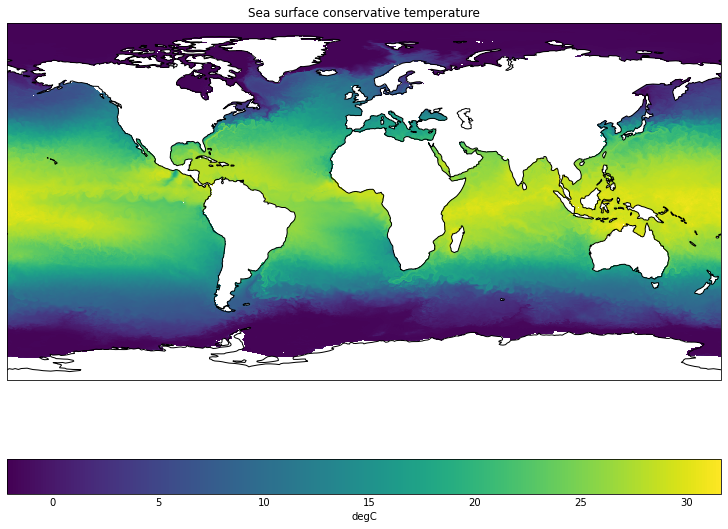

In [7]:
fig = plt.figure(figsize=[12.8, 9.6])
projected_cube, extent = iris.analysis.cartography.project(
    tos[0, ...], ccrs.PlateCarree()
)
qplt.pcolormesh(projected_cube)
plt.draw()
__ = plt.gca().coastlines()  # __ hides the return value in Notebooks

### Time mean

Calculate the area weighted global mean at each time slice and plot this series.

In [8]:
global_mean = tos.collapsed(
        ["latitude", "longitude"], iris.analysis.MEAN
    )

/opt/jaspy/lib/python3.10/site-packages/iris/cube.py:3696: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))


In [9]:
print(tos.summary(shorten=True))
print(global_mean.summary(shorten=True))

sea surface conservative temperature / (degC) (time: 90; latitude: 721; longitude: 1440)
sea surface conservative temperature / (degC) (time: 90)


/opt/jaspy/lib/python3.10/site-packages/iris/fileformats/netcdf.py:416: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  var = variable[keys]


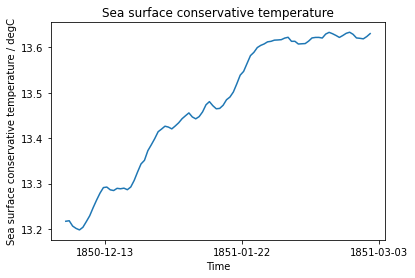

In [10]:
fig = plt.figure()
qplt.plot(global_mean)
plt.draw()